Cargar características espectrales

In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

In [2]:
Features_train_T = np.load('Caracteristicas\\train_audios_data.npy')
Features_val_T = np.load('Caracteristicas\\val_audios_data.npy')
Features_test_T = np.load('Caracteristicas\\test_audios_data.npy')

Labels_train_T = np.load('Caracteristicas\\train_audios_labels.npy')
Labels_val_T = np.load('Caracteristicas\\val_audios_labels.npy')
Labels_test_T = np.load('Caracteristicas\\test_audios_labels.npy')

# Transformación

encoder = OneHotEncoder()
y_trainT = encoder.fit_transform(np.array(Labels_train_T).reshape(-1, 1)).toarray()
y_validationT = encoder.transform(np.array(Labels_val_T).reshape(-1, 1)).toarray()
y_testT = encoder.transform(np.array(Labels_test_T).reshape(-1, 1)).toarray()

# Normalización de datos

scaler = StandardScaler()
x_trainT = scaler.fit_transform(Features_train_T)
x_validationT = scaler.transform(Features_val_T)
x_testT = scaler.transform(Features_test_T)

In [3]:
print(x_trainT.shape)
print(x_validationT.shape)
print(x_testT.shape)
print(y_trainT.shape)
print(y_validationT.shape)
print(y_testT.shape)

(46004, 162)
(5754, 162)
(5754, 162)
(46004, 7)
(5754, 7)
(5754, 7)


Cargar imágenes de espectrogramas procesadas:

In [4]:
x_trainI = np.load('Caracteristicas\\train_images_data.npy')
x_validationI = np.load('Caracteristicas\\val_images_data.npy')
x_testI = np.load('Caracteristicas\\test_images_data.npy')

Labels_train_I = np.load('Caracteristicas\\train_images_labels.npy')
Labels_val_I = np.load('Caracteristicas\\val_images_labels.npy')
Labels_test_I = np.load('Caracteristicas\\test_images_labels.npy')

# Transformación

encoder = OneHotEncoder()
y_trainI = encoder.fit_transform(np.array(Labels_train_I).reshape(-1, 1)).toarray()
y_validationI = encoder.transform(np.array(Labels_val_I).reshape(-1, 1)).toarray()
y_testI = encoder.transform(np.array(Labels_test_I).reshape(-1, 1)).toarray()

In [5]:
print(x_trainI.shape)
print(x_validationI.shape)
print(x_testI.shape)
print(y_trainI.shape)
print(y_validationI.shape)
print(y_testI.shape)

(46004, 64, 64)
(5754, 64, 64)
(5754, 64, 64)
(46004, 7)
(5754, 7)
(5754, 7)


Arquitectura de red neuronal y entrenamiento:

In [6]:
# Librerías para la red neuronal
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

In [7]:
# RED NEURONAL

featuresI_input = keras.Input(shape=(64, 64, 1), name="img_input")
featuresT_input = keras.Input(shape=(162, 1), name="data_input")

x1 = Conv2D(32, (3, 3), activation='relu')(featuresI_input)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
x1 = Dropout(0.05)(x1)

x1 = Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
x1 = Dropout(0.25)(x1)

x1 = Conv2D(512, kernel_size=(5, 5), padding='same', activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
x1 = Dropout(0.5)(x1)

x1 = Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
x1 = Dropout(0.3)(x1)

x1 = Flatten()(x1)

x2 = Conv1D(128, 3, padding ='same', activation='relu')(featuresT_input)
x2 = MaxPooling1D(pool_size=2, padding='same')(x2)
x2 = Dropout(0.25)(x2)

x2 = Conv1D(256, 5, padding ='same', activation='relu')(x2)
x2 = MaxPooling1D(pool_size=2, padding='same')(x2)
x2 = Dropout(0.45)(x2)

x2 = Conv1D(128, 5, padding ='same', activation='relu')(x2)
x2 = MaxPooling1D(pool_size=2, padding='same')(x2)
x2 = Dropout(0.5)(x2)

x2 = Flatten()(x2)

x = concatenate([x1, x2])

x = Dense(units=128, activation='relu') (x)
x = Dropout(0.15)(x)

class_output = Dense(units=7, activation='softmax', name="class_output")(x)

model = keras.Model(
    inputs=[featuresI_input, featuresT_input], outputs=[class_output]
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['img_input[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 31, 31, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 31, 31, 32)   0           ['max_pooling2d[0][0]']          
                                                                                              

In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit({"img_input": x_trainI, "data_input": x_trainT}, y_trainI, epochs=100, batch_size=64, validation_data=({"img_input": x_validationI, "data_input": x_validationT}, y_validationI),
                    callbacks=[stop_early])
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
719/719 [==============================] - 39s 40ms/step - loss: 1.6418 - accuracy: 0.3404 - val_loss: 1.3658 - val_accuracy: 0.4859
Epoch 2/100
719/719 [==============================] - 27s 38ms/step - loss: 1.3325 - accuracy: 0.4848 - val_loss: 1.1906 - val_accuracy: 0.5494
Epoch 3/100
719/719 [==============================] - 27s 38ms/step - loss: 1.1880 - accuracy: 0.5465 - val_loss: 1.0751 - val_accuracy: 0.5912
Epoch 4/100
719/719 [==============================] - 27s 38ms/step - loss: 1.0949 - accuracy: 0.5810 - val_loss: 1.0056 - val_accuracy: 0.6197
Epoch 5/100
719/719 [==============================] - 27s 38ms/step - loss: 1.0184 - accuracy: 0.6109 - val_loss: 0.9138 - val_accuracy: 0.6529
Epoch 6/100
719/719 [==============================] - 27s 38ms/step - loss: 0.9508 - accuracy: 0.6395 - val_loss: 0.8709 - val_accuracy: 0.6663
Epoch 7/100
719/719 [==============================] - 27s 38ms/step - loss: 0.8951 - accuracy: 0.6593 - val_loss: 0.8057 - val_ac

In [9]:
# RED NEURONAL

featuresI_input = keras.Input(shape=(64, 64, 1), name="img_input")
featuresT_input = keras.Input(shape=(162, 1), name="data_input")

x1 = Conv2D(32, (3, 3), activation='relu')(featuresI_input)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
x1 = Dropout(0.05)(x1)

x1 = Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
x1 = Dropout(0.25)(x1)

x1 = Conv2D(512, kernel_size=(5, 5), padding='same', activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
x1 = Dropout(0.5)(x1)

x1 = Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
x1 = Dropout(0.3)(x1)

x1 = Flatten()(x1)

x2 = Conv1D(128, 3, padding ='same', activation='relu')(featuresT_input)
x2 = MaxPooling1D(pool_size=2, padding='same')(x2)
x2 = Dropout(0.25)(x2)

x2 = Conv1D(256, 5, padding ='same', activation='relu')(x2)
x2 = MaxPooling1D(pool_size=2, padding='same')(x2)
x2 = Dropout(0.45)(x2)

x2 = Conv1D(128, 5, padding ='same', activation='relu')(x2)
x2 = MaxPooling1D(pool_size=2, padding='same')(x2)
x2 = Dropout(0.5)(x2)

x2 = Flatten()(x2)

x = concatenate([x1, x2])

x = Dense(units=128, activation='relu') (x)
x = Dropout(0.15)(x)

class_output = Dense(units=7, activation='softmax', name="class_output")(x)

hypermodel = keras.Model(
    inputs=[featuresI_input, featuresT_input], outputs=[class_output]
)

hypermodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


hypermodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 62, 62, 32)   320         ['img_input[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 31, 31, 32)  0           ['conv2d_4[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 31, 31, 32)   0           ['max_pooling2d_4[0][0]']        
                                                                                            

In [10]:
# Retrain the model
history = hypermodel.fit({"img_input": x_trainI, "data_input": x_trainT}, y_trainI, epochs=best_epoch, batch_size=64, validation_data=({"img_input": x_validationI, "data_input": x_validationT}, y_validationI))

Epoch 1/65
719/719 [==============================] - 28s 37ms/step - loss: 1.6397 - accuracy: 0.3439 - val_loss: 1.3799 - val_accuracy: 0.4765
Epoch 2/65
719/719 [==============================] - 26s 36ms/step - loss: 1.3370 - accuracy: 0.4797 - val_loss: 1.1864 - val_accuracy: 0.5565
Epoch 3/65
719/719 [==============================] - 26s 37ms/step - loss: 1.1984 - accuracy: 0.5378 - val_loss: 1.0864 - val_accuracy: 0.5831
Epoch 4/65
719/719 [==============================] - 27s 37ms/step - loss: 1.0938 - accuracy: 0.5773 - val_loss: 0.9830 - val_accuracy: 0.6248
Epoch 5/65
719/719 [==============================] - 26s 36ms/step - loss: 1.0130 - accuracy: 0.6103 - val_loss: 0.9047 - val_accuracy: 0.6568
Epoch 6/65
719/719 [==============================] - 26s 36ms/step - loss: 0.9421 - accuracy: 0.6389 - val_loss: 0.8368 - val_accuracy: 0.6872
Epoch 7/65
719/719 [==============================] - 26s 36ms/step - loss: 0.8887 - accuracy: 0.6580 - val_loss: 0.7964 - val_accuracy:

Gráficas, guardado y cargado

In [11]:
import pickle

# Guardar el objeto history
with open('Modelo\\history_modelo_EmoDSc.pkl', 'wb') as file:
    pickle.dump(history.history, file)

np.save('Modelo\\best_epoch_EmoDSc.npy', best_epoch)

hypermodel.summary()
hypermodel.save('Modelo\\modelo_EmoDSc.h5')
hypermodel.save_weights('Modelo\\pesos_EmoDSc.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 62, 62, 32)   320         ['img_input[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 31, 31, 32)  0           ['conv2d_4[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 31, 31, 32)   0           ['max_pooling2d_4[0][0]']        
                                                                                            

In [12]:
import pickle
from keras.models import load_model

# Cargar el objeto history
with open('Modelo\\history_modelo_EmoDSc.pkl', 'rb') as file:
    history = pickle.load(file)

hypermodel = load_model('Modelo\\modelo_EmoDSc.h5')
hypermodel.load_weights('Modelo\\pesos_EmoDSc.h5')

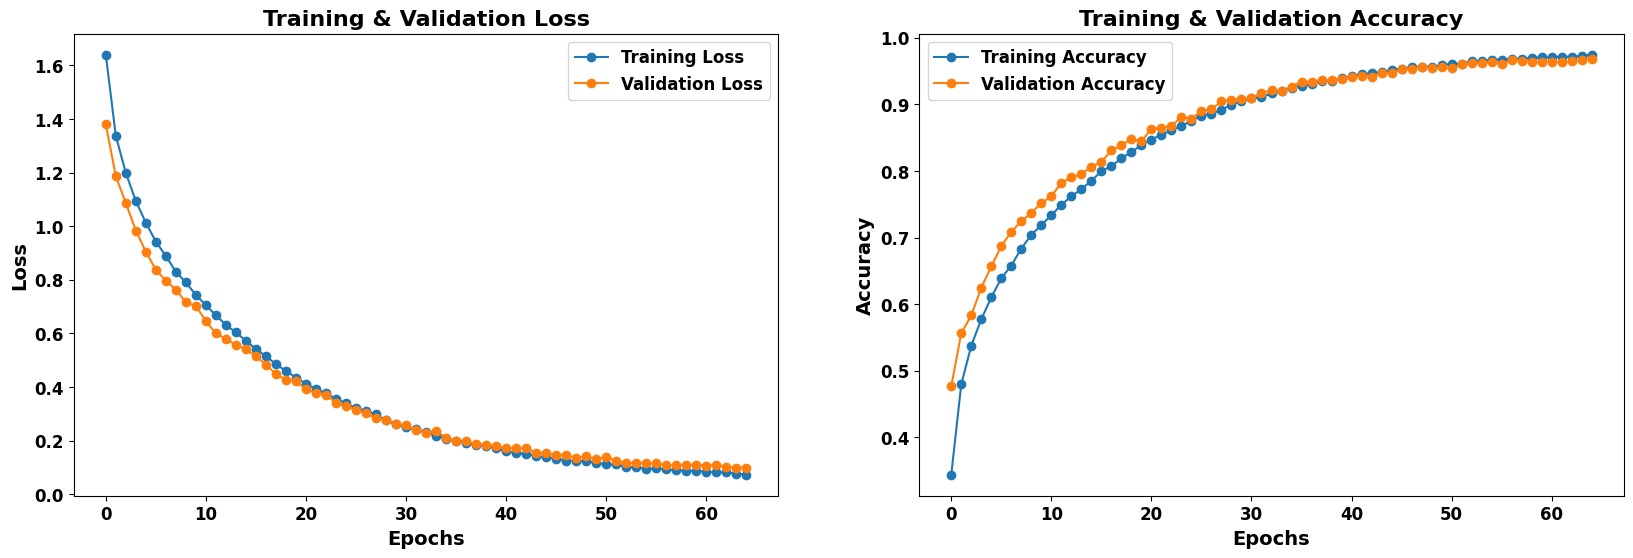

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# We plot the loss and accuracy
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# ... tu código anterior para obtener 'history' ...

# Configuramos el tamaño de las gráficas y las fuentes
plt.rcParams['font.size'] = 12  # Tamaño base de la fuente para las gráficas
plt.rcParams['axes.labelweight'] = 'bold'  # Etiquetas de los ejes en negrita

legend_font = FontProperties(weight='bold', size=12)

epochs = [i for i in range(best_epoch)]
fig, ax = plt.subplots(1, 2)
train_acc = history['accuracy']
train_loss = history['loss']
test_acc = history['val_accuracy']
test_loss = history['val_loss']

fig.set_size_inches(20, 6)

# Gráfica de la pérdida (loss)
ax[0].plot(epochs, train_loss, 'o-', label='Training Loss')
ax[0].plot(epochs, test_loss, 'o-', label='Validation Loss')
ax[0].set_title('Training & Validation Loss', fontsize=16, fontweight='bold')
ax[0].set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax[0].set_ylabel("Loss", fontsize=14, fontweight='bold')
ax[0].legend(prop=legend_font)
ax[0].tick_params(labelsize=12)

# Gráfica de la precisión (accuracy)
ax[1].plot(epochs, train_acc, 'o-', label='Training Accuracy')
ax[1].plot(epochs, test_acc, 'o-', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy', fontsize=16, fontweight='bold')
ax[1].set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax[1].set_ylabel("Accuracy", fontsize=14, fontweight='bold')
ax[1].legend(prop=legend_font)
ax[1].tick_params(labelsize=12)

for label in ax[0].get_xticklabels():
    label.set_weight('bold')

for label in ax[0].get_yticklabels():
    label.set_weight('bold')

for label in ax[1].get_xticklabels():
    label.set_weight('bold')

for label in ax[1].get_yticklabels():
    label.set_weight('bold')

plt.show()

fig.savefig("./Figuras/Graficas_EmoDSc.eps", format='eps')

180/180 [==============================] - 2s 7ms/step
[array(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness',
       'Surprise'], dtype='<U9')]
['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']


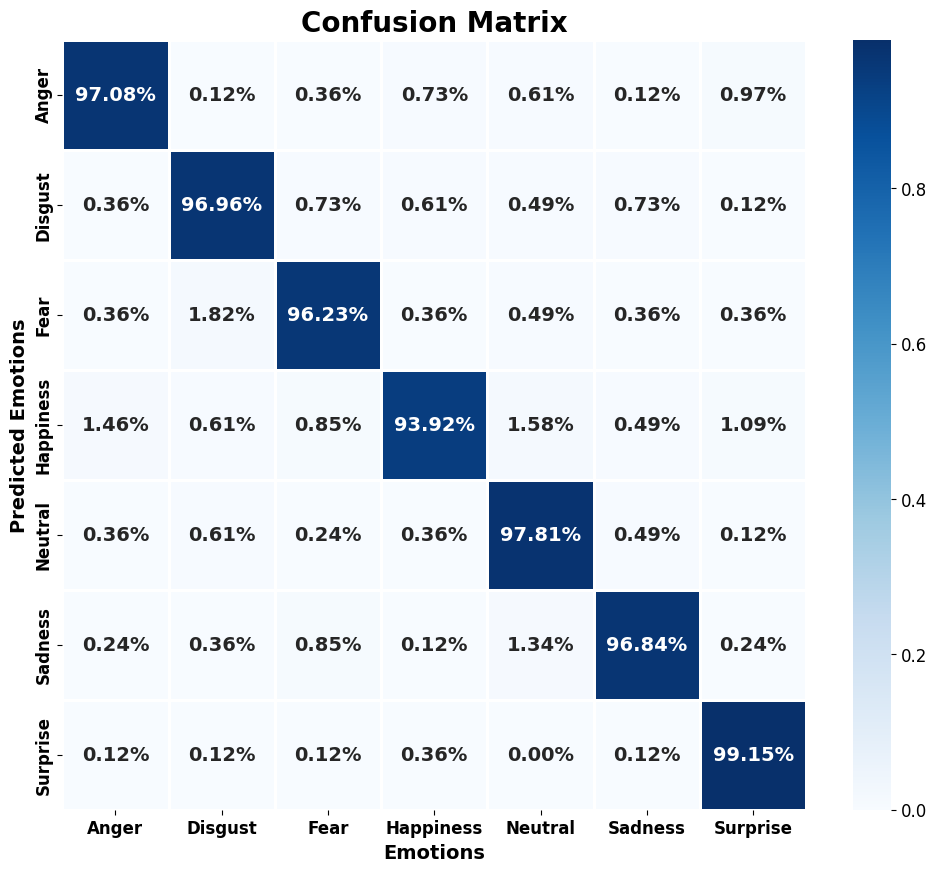

              precision    recall  f1-score   support

       Anger       0.97      0.97      0.97       822
     Disgust       0.96      0.97      0.97       822
        Fear       0.97      0.96      0.97       822
   Happiness       0.97      0.94      0.96       822
     Neutral       0.96      0.98      0.97       822
     Sadness       0.98      0.97      0.97       822
    Surprise       0.97      0.99      0.98       822

    accuracy                           0.97      5754
   macro avg       0.97      0.97      0.97      5754
weighted avg       0.97      0.97      0.97      5754



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

# predicting on test data.
pred_test = hypermodel.predict({"img_input": x_validationI, "data_input": x_validationT})
y_pred = encoder.inverse_transform(pred_test)

y_validation = encoder.inverse_transform(y_validationI)

df = pd.DataFrame(columns=['Predicted Emotions', 'Emotions'])
df['Predicted Emotions'] = y_pred.flatten()
df['Emotions'] = y_validation.flatten()

df.head(10)

cm = confusion_matrix(y_validation, y_pred) / 822

E = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']
print(encoder.categories_)
print(E)

plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in E], columns=[
                  i for i in E])
sns.heatmap(cm, linecolor='white', cmap='Blues',
            linewidth=1, annot=True, fmt='.2%', annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix', size=20, weight='bold')
plt.xlabel('Emotions', size=14, weight='bold')
plt.ylabel('Predicted Emotions', size=14, weight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the figure as EPS
plt.savefig('Figuras\\ConfusionTest_EmoDSc.eps', format='eps', dpi=300)

plt.show()

print(classification_report(y_validation, y_pred))

180/180 [==============================] - 1s 6ms/step
[array(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness',
       'Surprise'], dtype='<U9')]
['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']


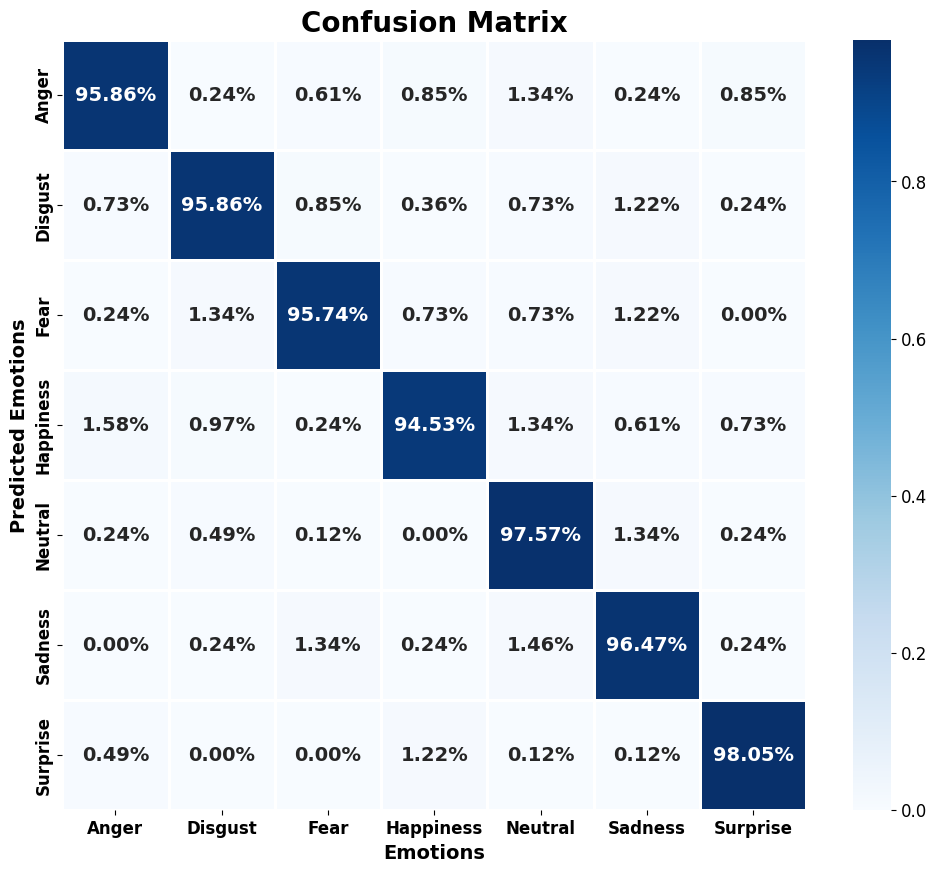

              precision    recall  f1-score   support

       Anger       0.97      0.96      0.96       822
     Disgust       0.97      0.96      0.96       822
        Fear       0.97      0.96      0.96       822
   Happiness       0.97      0.95      0.96       822
     Neutral       0.94      0.98      0.96       822
     Sadness       0.95      0.96      0.96       822
    Surprise       0.98      0.98      0.98       822

    accuracy                           0.96      5754
   macro avg       0.96      0.96      0.96      5754
weighted avg       0.96      0.96      0.96      5754



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

# predicting on test data.
pred_test = hypermodel.predict({"img_input": x_testI, "data_input": x_testT})
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_testI)

df = pd.DataFrame(columns=['Predicted Emotions', 'Emotions'])
df['Predicted Emotions'] = y_pred.flatten()
df['Emotions'] = y_test.flatten()

df.head(10)

cm = confusion_matrix(y_test, y_pred) / 822

E = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']
print(encoder.categories_)
print(E)

plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in E], columns=[
                  i for i in E])
sns.heatmap(cm, linecolor='white', cmap='Blues',
            linewidth=1, annot=True, fmt='.2%', annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix', size=20, weight='bold')
plt.xlabel('Emotions', size=14, weight='bold')
plt.ylabel('Predicted Emotions', size=14, weight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the figure as EPS
plt.savefig('Figuras\\ConfusionTest_EmoDSc.eps', format='eps', dpi=300)

plt.show()

print(classification_report(y_test, y_pred))